In [2]:
# !pip install control
from scipy.io import loadmat
import numpy as np
from numpy import *
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pickle
from control import lqr, ss
from control.matlab import lsim

# **The cart and pole system**

Consider the cart-and-pole system here depicted:
<div>
<img src="https://drive.google.com/uc?export=view&id=1Yu5zZ57OEEYZ678yWLaU7h-Wq3M9vV9E" width="200">
</div>
whose dynamics follows the following equations:

\begin{align}
  \ddot{\theta}&=\frac{g \sin(\theta)\,+\,\cos(\theta) \left[ \frac{-F\,-\,m_p\,l\,\dot{\theta}^2 \sin \left(\theta\right)}{m_c\,+\,m_p}\right]-\frac{\mu_p\dot{\theta}}{m_p\,l}}{l\,\left[\frac{4}{3}-\frac{m_p\,cos^2\left(\theta\right)}{m_c\,+\,m_p}\right]}
\end{align}
>>>>>>>>>>>>>>>>>>>>>>>>$(*)$

\begin{align}
  \ddot{p}_c&=\frac{F\,+\,m_p\,l\,\left[\dot{\theta}^2\,\sin\left(\theta\right)\,-\,\ddot{\theta}\,\cos(\theta)\right]}{m_c\,+\,m_p}
\end{align}

where $g = 9.8\,\text{m/sec}$ is the gravitational acceleration, $m_c = 1\,\text{kg}$ is the cart mass, $m_p = 0.1\,\text{kg}$ is the pole mass, $l = 0.5\,\text{m}$ is the half-pole length, $\mu_p = 0.000002$ is the pole on cart friction coefficient, and $F:|F|\leq 10\,\text{N}$ is the force applied to cart's center of mass.

# 1. Clearly define an optimal control problem for pole balancing

Pole balancing is a classic problem in control theory where the goal is to maintain the balance of an inverted pendulum (pole) on a moving platform. The optimal control problem for pole balancing involves finding a control policy that minimizes a cost function while ensuring the stability of the system. Here's a more detailed formulation:

**System dynamics**

Consider a simple inverted pendulum system with a cart that can move horizontally. The state of the system is described by the position of the cart ($p_c$) and the angle of the pole $\theta$). The dynamics of the system can be modeled using differential equations, such as the nonlinear equations of motion for an inverted pendulum.

**Objective**

Define a cost function that captures the performance and stability of the system. The objective is to find a control policy that minimizes this cost function over a specified time horizon.


The optimal control problem can be formulated as finding the control input $u(t)$ that minimizes the cost function while satisfying the system dynamics and any constraints:

$min_{⁡u(t)}J(x(t),\theta(t),u(t))$

subject to the dynamics of the system and any imposed constraints.

Solving this optimal control problem will yield a control policy that stabilizes the inverted pendulum while satisfying the specified performance criteria.

# 2. Is the LQR applicable in its simple form on the system? If not what is missed?




LQR can be applied on the pole balancing problem, but only if we can linearize the system.

# 3. Design an LQR for the linearized version of the cart and pole obtained in the previous hands-on. Justify all the design choices and perform all the required checks

In [3]:
def cart_and_pole_lin(x, t, F):
    dxdt = np.zeros_like(x)

    dxdt[0] = x[1] #tetap
    dxdt[1] = 0 #teta2p
    for i in range(len(x)):
        dxdt[1] += theta2p_lin[i]*(x[i] - xeq[i])
    dxdt[2] = x[3] #xp
    dxdt[3] = 0 #x2p
    for i in range(len(x)):
        dxdt[3] += x2p_lin[i]*(x[i] - xeq[i])
    return dxdt

with open('linearized_model.pkl', 'rb') as file: 
    linearized_model = pickle.load(file)

In [4]:
theta2p_linA = linearized_model["theta2p_linA"]
x2p_linA = linearized_model["x2p_linA"]

Let's define the state space model of the system

$x = \left( \begin{array}{ccc}
                \theta \\
                \dot \theta \\
                p_c \\
                \dot p_c
\end{array} \right)
=
\left( \begin{array}{ccc}
                  x_1 \\
                  x_2 \\
                  x_3 \\
                  x_4
\end{array} \right)$

In [5]:
A = np.array([
    [0, 1, 0, 0],
    theta2p_linA,
    [0, 0, 0, 1],
    x2p_linA
])
B = np.array([
    [0],
    [linearized_model["theta2p_linB"]],
    [0],
    [linearized_model["x2p_linB"]]
])
C = np.array([
    [1,  0,  0,  0],
    [0,  1,  0,  0],
    [0,  0,  1,  0],
    [0,  0,  0,  1]
])
D = 0

Let's check observability and controllability of the system

In [6]:
Q = np.array([
    [1,  0,  0,  0],
    [0,  0,  0,  0],
    [0,  0,  10, 0],
    [0,  0,  0,  0]
])
R = 10

K, S, E = lqr(A, B, Q, R)

# 4.    Simulate the linearized cart and pole system controlled by an LQR. Plot the significant behaviors

In [7]:
A_c = A - B * K
S = ss(A_c, B, C, D)
#uvec = loadmat('U.mat')
#uvec = uvec['U'][0]

time_step=0.02
time_sim=np.arange(0.0, 20, time_step)

uvec = np.zeros_like(time_sim)
uvec[0] = 10

In [8]:
yout, T, xout = lsim(S, uvec, time_sim)

Text(0.5, 1.0, 'theta(t)')

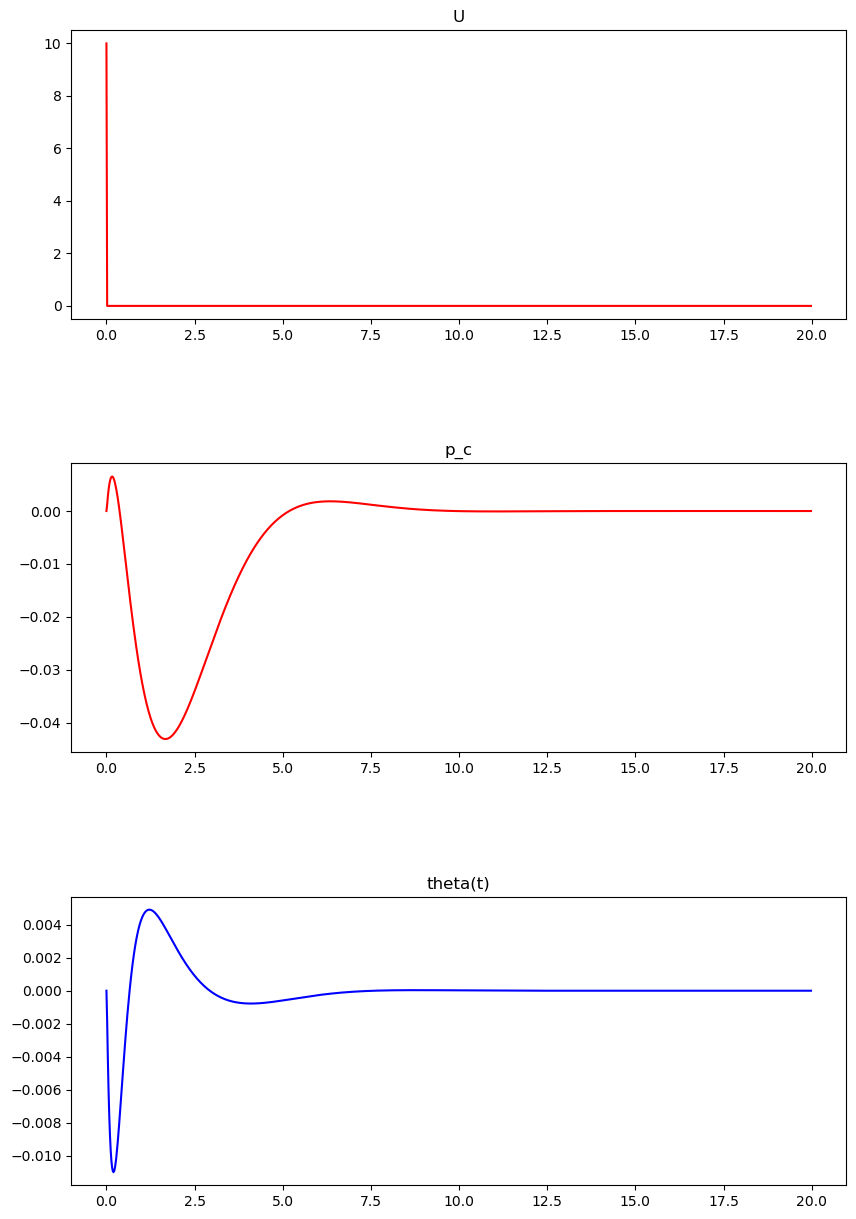

In [9]:
plt.rcParams['figure.figsize'] = [10, 15]
fig, axs = plt.subplots(3)
fig.subplots_adjust(hspace=0.5)

axs[0].plot(time_sim, uvec, 'r', label='U(t)')
axs[0].set_title("U")

axs[1].plot(time_sim, xout[:,2], 'r', label='U(t)')
axs[1].set_title("p_c")

axs[2].plot(time_sim, xout[:,0], 'b')
axs[2].set_title("theta(t)")

# 5.  Simulate the non-linear cart and pole system controlled by the previously obtained LQR. Plot the significant behaviors

In [36]:
t0_odeint=0
x0_odeint = np.array([0.0, 0.0, 0.0, 0.0])
X_odeint=[x0_odeint]

g = 9.8 # gravitational acceleration
mc = 1  # cart mass [kg]
l = 0.5 # half-pole length [m]
m = 0.1 # pole mass [kg]
miup = 2e-6 # pole friction coefficient

# let's set the input force to 0
F = 0 # N

In [37]:
def cart_and_pole_odeint(x, t, F):
  dxdt = np.zeros_like(x)

  dxdt[0] = x[1] #tetap
  dxdt[1] = (g*sin(x[0])+ cos(x[0])*((-F-m*l*(x[1]**2)*sin(x[0]))/(mc+m))-((miup*x[1])/(m*l))) / (l*((4/3)-((m*(cos(x[0])**2))/(mc+m))))    #teta2p
  dxdt[2] = x[3] #xp
  dxdt[3] = (F+m*l*((x[1]**2)*sin(x[0])-dxdt[1]*cos(x[0])))/(mc+m) #x2p
  return dxdt

In [38]:
for i in range(len(uvec)):
    t1_odeint = t0_odeint+0.02
    t_odeint = np.array([t0_odeint, t1_odeint])
    F = uvec[i]
    x_odeint = odeint(cart_and_pole_odeint, x0_odeint, t_odeint, args=(F, ))
    x0_odeint = x_odeint[1]
    X_odeint=np.append(X_odeint, [x0_odeint], axis= 0)
    
    if i < len(uvec)-1:
        uvec[i+1] = -(K * x0_odeint[np.newaxis].T)[0][0]

Text(0.5, 1.0, 'theta(t)')

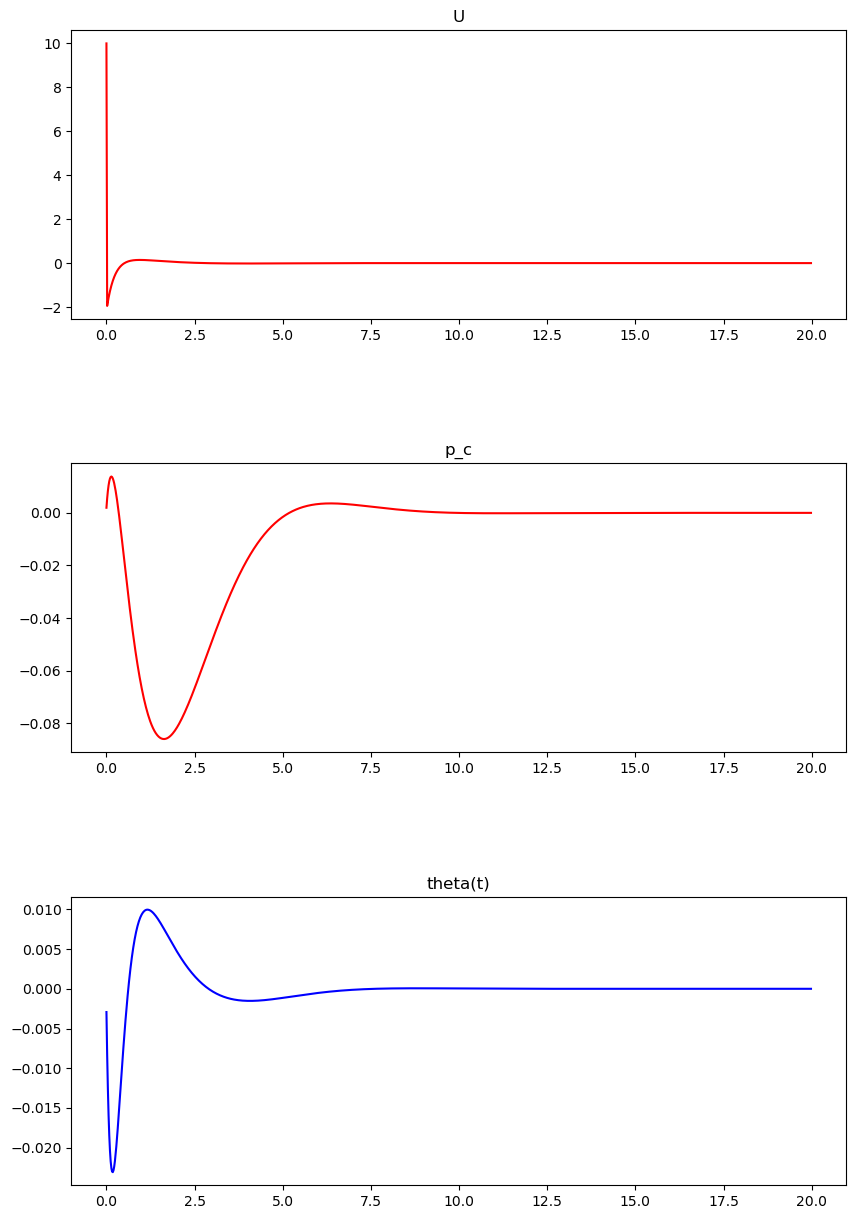

In [39]:
plt.rcParams['figure.figsize'] = [10, 15]
fig, axs = plt.subplots(3)
fig.subplots_adjust(hspace=0.5)

axs[0].plot(time_sim, uvec, 'r', label='U(t)')
axs[0].set_title("U")

axs[1].plot(time_sim, X_odeint[1:,2], 'r', label='U(t)')
axs[1].set_title("p_c")

axs[2].plot(time_sim, X_odeint[1:,0], 'b')
axs[2].set_title("theta(t)")

# 6. Comment results obtained in the two simulations

Text(0.5, 1.0, 'theta(t)')

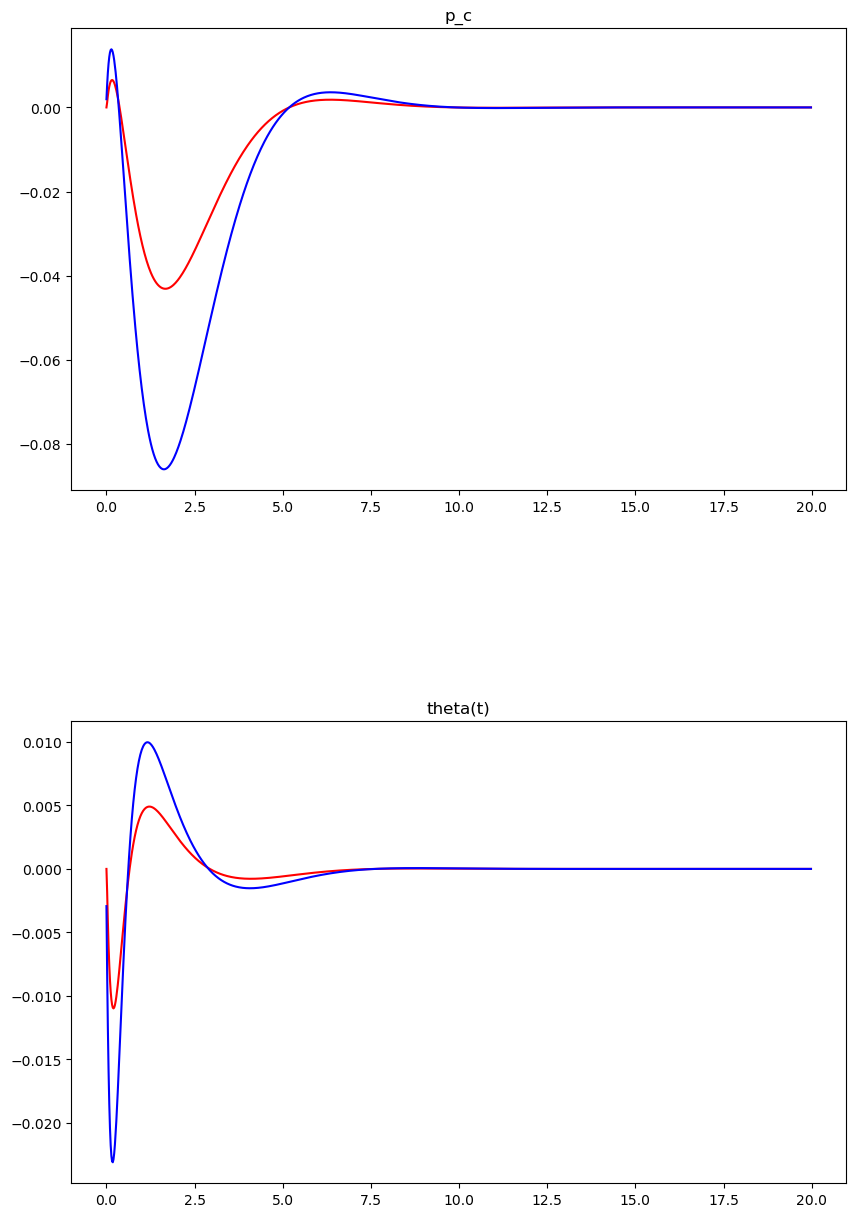

In [41]:
plt.rcParams['figure.figsize'] = [10, 15]
fig, axs = plt.subplots(2)
fig.subplots_adjust(hspace=0.5)

axs[0].plot(time_sim, xout[:,2], 'r', label='U(t)')
axs[0].plot(time_sim, X_odeint[1:,2], 'b', label='U(t)')
axs[0].set_title("p_c")

axs[1].plot(time_sim, xout[:,0], 'r')
axs[1].plot(time_sim, X_odeint[1:,0], 'b')
axs[1].set_title("theta(t)")